In [74]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut, StratifiedShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from collections import Counter
from scipy import stats
%matplotlib inline

In [75]:
sns.set_context('paper', font_scale=2.5)
sns.set_style('white')

In [76]:
os.chdir("../2_Data")
os.getcwd()

'/Users/zhengyuanrui/Decoding_SALT/2_Data'

In [77]:
df1 = pd.read_csv("Exp1_postpro.csv")
df2 = pd.read_csv("Exp2_postpro.csv")

In [78]:
df1 = df1.dropna()

In [79]:
df1['rt'] = np.log(df1['rt'])

In [80]:
df1['matchness'] = df1['matchness'].map(dict(match=1, mismatch=0))

In [81]:
df2 = df2.dropna()

In [82]:
df2['rt'] = np.log(df2['rt'])

In [83]:
df2['matchness'] = df2['matchness'].map(dict(match=1, mismatch=0))

In [84]:
onehot_s1 = pd.get_dummies(df1[["condition"]])

In [85]:
df1 = pd.concat([df1, onehot_s1], axis=1)

In [86]:
onehot_s2 = pd.get_dummies(df2[["condition"]])

In [87]:
df2 = pd.concat([df2, onehot_s2], axis=1)

In [88]:
df1

,subj_idx,gender,year,education,dist,trial_type,rt,response,key_press,condition,...,Image,shape_en,valence,ACC,exp,matchness,trial_id,condition_image_first,condition_simultaneous,condition_word_first
0,1,0,2000,5,434.97,psychophysics,6.773080,f,f,image_first,...,img/C_ambi40.png,circle,triangle,1,exp1,0,1,1,0,0
1,1,0,2000,5,434.97,psychophysics,6.507278,j,j,image_first,...,img/C_ambi40.png,circle,circle,1,exp1,1,2,1,0,0
2,1,0,2000,5,434.97,psychophysics,6.386879,j,j,image_first,...,img/T_ambi40.png,triangle,triangle,1,exp1,1,3,1,0,0
3,1,0,2000,5,434.97,psychophysics,6.469250,f,f,image_first,...,img/S_ambi40.png,square,circle,1,exp1,0,4,1,0,0
4,1,0,2000,5,434.97,psychophysics,6.350886,j,j,image_first,...,img/S_ambi40.png,square,square,1,exp1,1,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,9,0,2003,4,467.59,psychophysics,6.436150,f,f,word_first,...,img/T_ambi40.png,triangle,square,1,exp1,0,236,0,0,1
28796,9,0,2003,4,467.59,psychophysics,6.383507,j,j,word_first,...,img/T_ambi40.png,triangle,triangle,1,exp1,1,237,0,0,1
28797,9,0,2003,4,467.59,psychophysics,6.326149,f,f,word_first,...,img/T_ambi40.png,triangle,circle,1,exp1,0,238,0,0,1
28798,9,0,2003,4,467.59,psychophysics,6.347389,j,j,word_first,...,img/C_ambi40.png,circle,circle,1,exp1,1,239,0,0,1


In [89]:
df1_circle = df1[df1.valence == "circle"]
df1_triangle = df1[df1.valence == "triangle"]
df1_square = df1[df1.valence == "square"]

df2_good = df2[df2.valence == "Good"]
df2_bad = df2[df2.valence == "Bad"]
df2_neutral = df2[df2.valence == "Neutral"]

In [90]:
y1_circle = df1_circle["matchness"].values
y1_triangle = df1_triangle["matchness"].values
y1_square = df1_square["matchness"].values

y2_good = df2_good["matchness"].values
y2_bad = df2_bad["matchness"].values
y2_neutral = df2_neutral["matchness"].values

In [91]:
X1_circle = df1_circle[['rt', "ACC", "condition_image_first", "condition_simultaneous", "condition_word_first"]].values
X1_triangle = df1_triangle[['rt', "ACC", "condition_image_first", "condition_simultaneous", "condition_word_first"]].values
X1_square = df1_square[['rt', "ACC", "condition_image_first", "condition_simultaneous", "condition_word_first"]].values

X2_good = df2_good[['rt', "ACC", "condition_image_first", "condition_simultaneous", "condition_word_first"]].values
X2_bad = df2_bad[['rt', "ACC", "condition_image_first", "condition_simultaneous", "condition_word_first"]].values
X2_neutral = df2_neutral[['rt', "ACC", "condition_image_first", "condition_simultaneous", "condition_word_first"]].values

In [92]:
groups1_cirlce = df1_circle["subj_idx"].values
groups1_triangle = df1_triangle["subj_idx"].values
groups1_square = df1_square["subj_idx"].values

groups2_good = df2_good["subj_idx"].values
groups2_bad = df2_bad["subj_idx"].values
groups2_neutral = df2_neutral["subj_idx"].values

In [93]:
def lr_Cross(X_source, y_source, source_groups,source_name, X_target1, y_target1, target1_groups, target_name1, X_target2, y_target2, target2_gorups, target_name2, fold):
    df_result = dict(sub=[], score=[], fold=[], source=[], target=[])# source拟合的，target预测的condition
    for sub in np.unique(source_groups):
        idx_sub = source_groups == sub
        feature_sub_source = X_source[idx_sub]
        label_sub_source = y_source[idx_sub]
        cv = StratifiedShuffleSplit(n_splits=fold, test_size=0.2, random_state=1)#n_split要很大
        logi = make_pipeline(
        StandardScaler(), 
        LogisticRegressionCV(Cs = np.logspace(-3, 3, 7), cv = 5, class_weight='balanced', random_state=123))
        score = cross_validate(logi, feature_sub_source, label_sub_source, cv=cv, scoring="roc_auc",n_jobs=-1, return_estimator=True)

        estimators = score["estimator"]

        for ii, s in enumerate(score["test_score"]):
            df_result["sub"].append(sub)
            df_result["score"].append(s)
            df_result["fold"].append(ii)
            df_result["source"].append(source_name)
            df_result["target"].append(source_name)
        
        for ii, estimator, in enumerate(estimators):
            y_true_t1 = y_target1[target1_groups == sub]
            
            y_pred_t1 = estimator.predict_proba(X_target1[target1_groups == sub])
            roc_t1 = roc_auc_score(y_true_t1, y_pred_t1[:, -1])

            df_result["sub"].append(sub)  
            df_result["score"].append(roc_t1)
            df_result["fold"].append(ii)
            df_result["source"].append(source_name)
            df_result["target"].append(target_name1)

            y_true_t2 = y_target2[target2_gorups == sub]
            y_pred_t2 = estimator.predict_proba(X_target2[target2_gorups==sub])

            roc_t2 = roc_auc_score(y_true_t2, y_pred_t2[:, -1])

            df_result["sub"].append(sub)  
            df_result["score"].append(roc_t2)
            df_result["fold"].append(ii)
            df_result["source"].append(source_name)
            df_result["target"].append(target_name2)



    return pd.DataFrame(df_result) 


In [94]:
df1_sc = lr_Cross(X_source = X1_circle, y_source = y1_circle, source_groups = groups1_cirlce,source_name = "Circle", X_target1 = X1_square, y_target1 = y1_square, target1_groups = groups1_square, target_name1 = "Square", X_target2 = X1_triangle, y_target2 = y1_triangle, target2_gorups = groups1_triangle, target_name2 = "Triangle", fold = 300)
df1_ss = lr_Cross(X_source = X1_square, y_source = y1_square, source_groups = groups1_square,source_name = "Square", X_target1 = X1_circle, y_target1 = y1_circle, target1_groups = groups1_cirlce, target_name1 = "Circle", X_target2 = X1_triangle, y_target2 = y1_triangle, target2_gorups = groups1_triangle, target_name2 = "Triangle", fold = 300)
df1_st = lr_Cross(X_source = X1_triangle, y_source = y1_triangle, source_groups = groups1_triangle,source_name = "Triangle", X_target1 = X1_circle, y_target1 = y1_circle, target1_groups = groups1_cirlce, target_name1 = "Circle", X_target2 = X1_square, y_target2 = y1_square, target2_gorups = groups1_square, target_name2 = "Square", fold = 300)

df2_sg = lr_Cross(X_source = X2_good, y_source = y2_good, source_groups = groups2_good, source_name = "Good", X_target1 = X2_bad, y_target1 = y2_bad, target1_groups = groups2_bad, target_name1 = "Bad", X_target2 = X2_neutral, y_target2 = y2_neutral, target2_gorups = groups2_neutral, target_name2 = "Neutral", fold = 300)
df2_sb = lr_Cross(X_source = X2_bad, y_source = y2_bad, source_groups = groups2_bad, source_name = "Bad", X_target1 = X2_good, y_target1 = y2_good, target1_groups = groups2_good, target_name1 = "Good", X_target2 = X2_neutral, y_target2 = y2_neutral, target2_gorups = groups2_neutral, target_name2 = "Neutral", fold = 300)
df2_sn = lr_Cross(X_source = X2_neutral, y_source = y2_neutral, source_groups = groups2_neutral, source_name = "Neutral", X_target1 = X2_good, y_target1 = y2_good, target1_groups = groups2_good, target_name1 = "Good", X_target2 = X2_bad, y_target2 = y2_bad, target2_gorups = groups2_bad, target_name2 = "Bad", fold = 300)

In [95]:
df_result1 = pd.concat([df1_sc, df1_ss, df1_st])

In [96]:
df_result1.to_csv('result1_cross_valence1.csv')

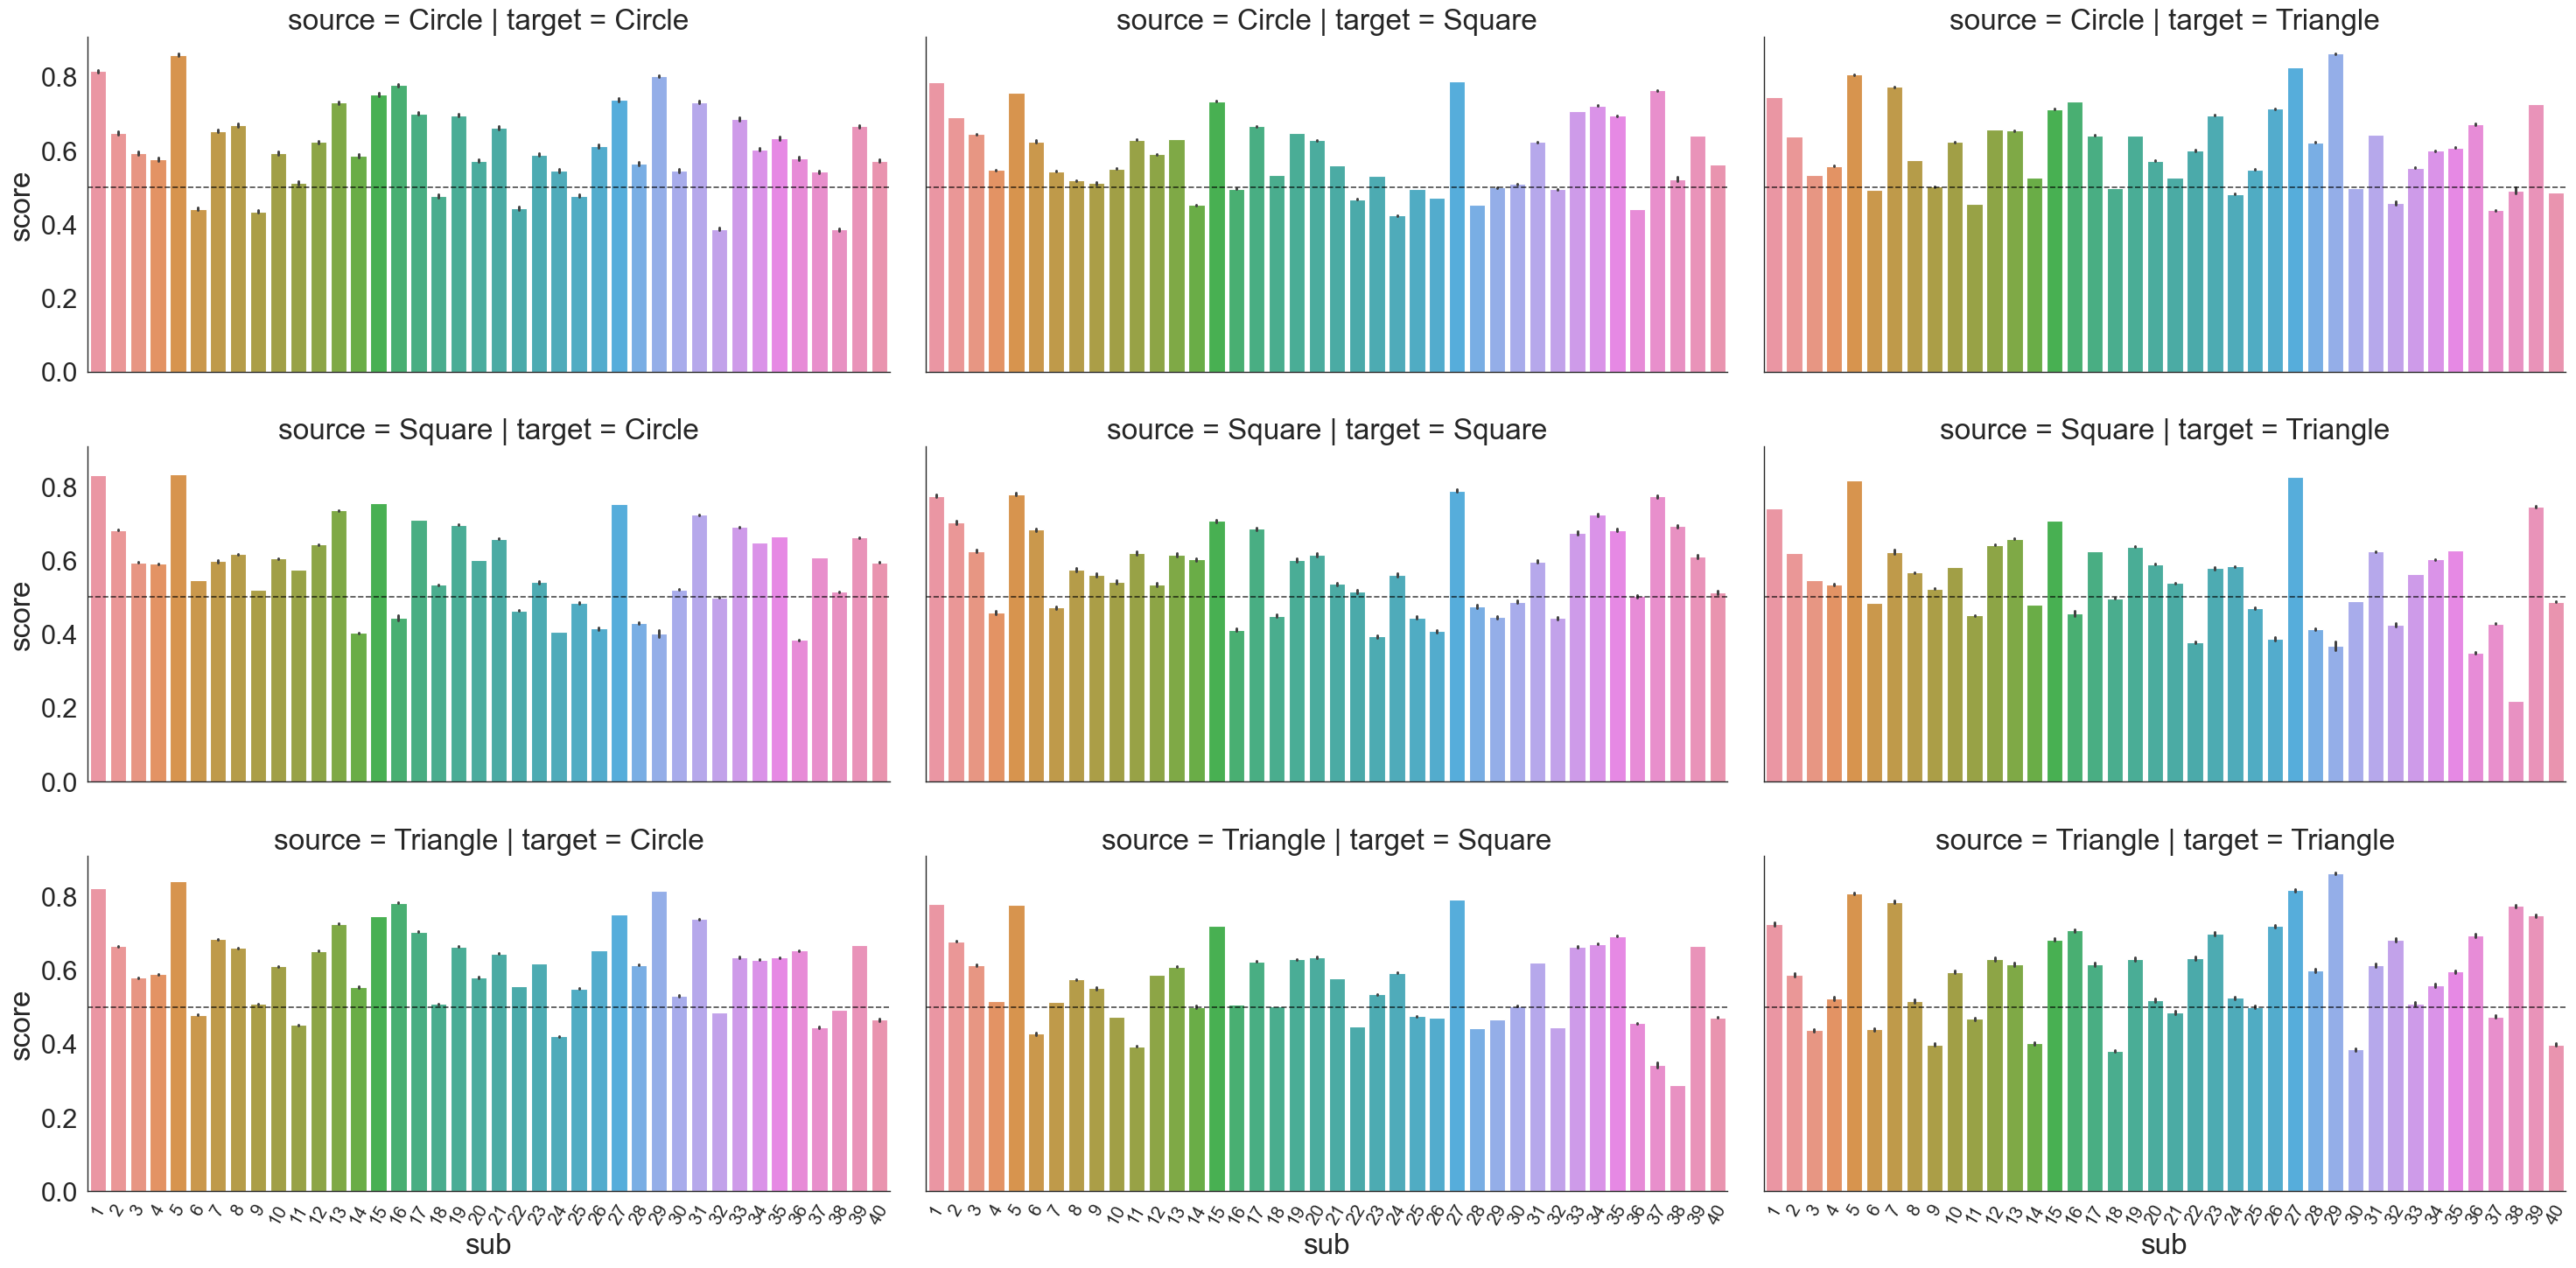

In [97]:
r1 = sns.catplot(x="sub", y="score", data=df_result1, row="source", col="target", aspect=2, errorbar="se", kind="bar")
xtick_order = list(r1.axes[-1][-1].xaxis.get_majorticklabels())
[ax.set_xticklabels(xtick_order, rotation = 60, fontsize=15) for ax in r1.axes[-1]]
[ax.axhline(0.5, linestyle = '--',color = 'black',alpha = 0.7) for ax in r1.axes.flatten()]
plt.savefig("barplot_cro_valence1.png",dpi=300)

In [98]:
df_result2 = pd.concat([df2_sg, df2_sb, df2_sn])

In [99]:
df_result2.to_csv('result1_cross_valence2.csv')

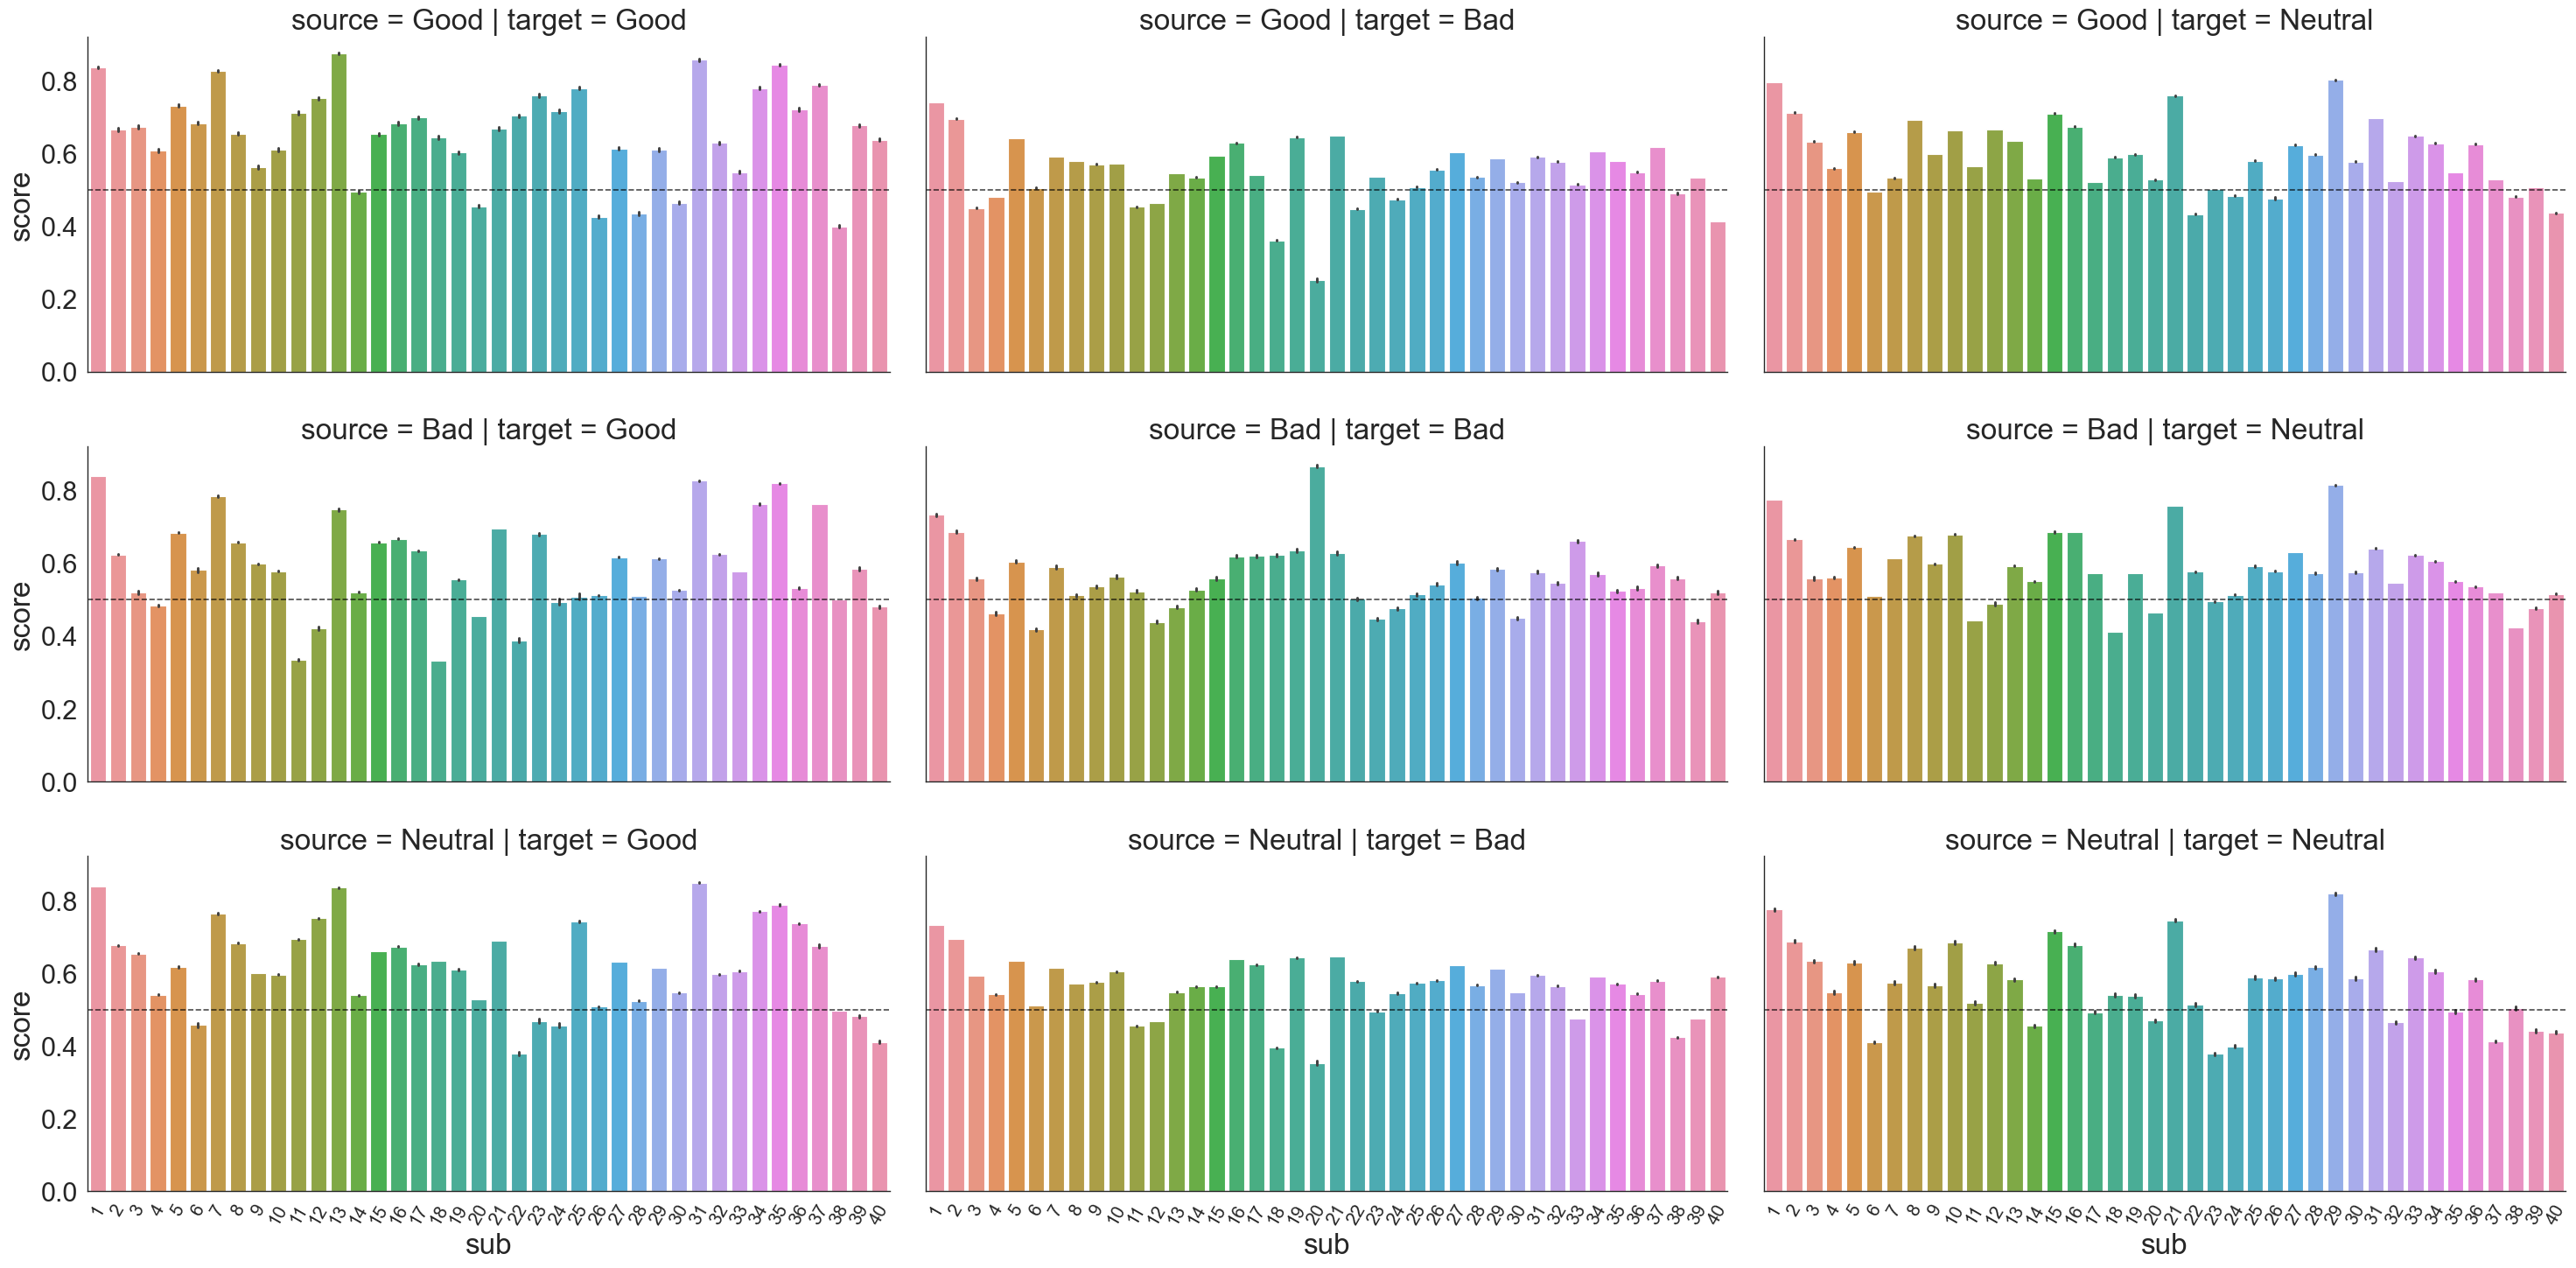

In [100]:
r2 = sns.catplot(x="sub", y="score", data=df_result2, row="source", col="target", aspect=2, errorbar="se", kind="bar")
xtick_order = list(r2.axes[-1][-1].xaxis.get_majorticklabels())
[ax.set_xticklabels(xtick_order, rotation = 60, fontsize=15) for ax in r2.axes[-1]]
[ax.axhline(0.5, linestyle = '--',color = 'black',alpha = 0.7) for ax in r2.axes.flatten()]
plt.savefig("barplot_cro_valence2.png",dpi=300)

In [101]:
def lr_Cross_exp(X_source, y_source, source_groups,source_name, X_target1, y_target1, target1_groups, target_name1, X_target2, y_target2, target2_gorups, target_name2, X_target3, y_target3, target3_gorups, target_name3, cross_dir, fold):
    df_result = dict(sub=[], score=[], fold=[], source=[], target=[], experiment=[])# source拟合的，target预测的condition
    for sub in np.unique(source_groups):
        idx_sub = source_groups == sub
        feature_sub_source = X_source[idx_sub]
        label_sub_source = y_source[idx_sub]
        cv = StratifiedShuffleSplit(n_splits=fold, test_size=0.2, random_state=1)#n_split要很大
        logi = make_pipeline(
        StandardScaler(), 
        LogisticRegressionCV(Cs = np.logspace(-3, 3, 7), cv = 5, class_weight='balanced', random_state=123))
        score = cross_validate(logi, feature_sub_source, label_sub_source, cv=cv, scoring="roc_auc",n_jobs=-1, return_estimator=True)

        estimators = score["estimator"]

        
        for ii, estimator, in enumerate(estimators):
            y_true_t1 = y_target1[target1_groups == sub]
            
            y_pred_t1 = estimator.predict_proba(X_target1[target1_groups == sub])
            roc_t1 = roc_auc_score(y_true_t1, y_pred_t1[:, -1])

            df_result["sub"].append(sub)  
            df_result["score"].append(roc_t1)
            df_result["fold"].append(ii)
            df_result["source"].append(source_name)
            df_result["target"].append(target_name1)
            df_result["experiment"].append(cross_dir)

            y_true_t2 = y_target2[target2_gorups == sub]
            y_pred_t2 = estimator.predict_proba(X_target2[target2_gorups==sub])

            roc_t2 = roc_auc_score(y_true_t2, y_pred_t2[:, -1])

            df_result["sub"].append(sub)  
            df_result["score"].append(roc_t2)
            df_result["fold"].append(ii)
            df_result["source"].append(source_name)
            df_result["target"].append(target_name2)
            df_result["experiment"].append(cross_dir)

            y_true_t3 = y_target3[target3_gorups == sub]
            y_pred_t3 = estimator.predict_proba(X_target3[target3_gorups==sub])

            roc_t3 = roc_auc_score(y_true_t3, y_pred_t3[:, -1])

            df_result["sub"].append(sub)  
            df_result["score"].append(roc_t3)
            df_result["fold"].append(ii)
            df_result["source"].append(source_name)
            df_result["target"].append(target_name3)
            df_result["experiment"].append(cross_dir)



    return pd.DataFrame(df_result) 


In [102]:
df_cro12_sc = lr_Cross_exp(X_source = X1_circle, y_source = y1_circle, source_groups = groups1_cirlce, source_name = "Circle", X_target1 = X2_bad, y_target1 = y2_bad, target1_groups = groups2_bad, target_name1 = "Bad", X_target2 = X2_good, y_target2 = y2_good, target2_gorups = groups2_good, target_name2 = "Good", X_target3 = X2_neutral, y_target3 = y2_neutral, target3_gorups = groups2_neutral, target_name3 = "Neutral", cross_dir = "exp1 → exp2", fold = 300)
df_cro12_ss = lr_Cross_exp(X_source = X1_square, y_source = y1_square, source_groups = groups1_square, source_name = "Square", X_target1 = X2_bad, y_target1 = y2_bad, target1_groups = groups2_bad, target_name1 = "Bad", X_target2 = X2_good, y_target2 = y2_good, target2_gorups = groups2_good, target_name2 = "Good", X_target3 = X2_neutral, y_target3 = y2_neutral, target3_gorups = groups2_neutral, target_name3 = "Neutral", cross_dir = "exp1 → exp2", fold = 300)
df_cro12_st = lr_Cross_exp(X_source = X1_triangle, y_source = y1_triangle, source_groups = groups1_triangle, source_name = "Triangle", X_target1 = X2_bad, y_target1 = y2_bad, target1_groups = groups2_bad, target_name1 = "Bad", X_target2 = X2_good, y_target2 = y2_good, target2_gorups = groups2_good, target_name2 = "Good", X_target3 = X2_neutral, y_target3 = y2_neutral, target3_gorups = groups2_neutral, target_name3 = "Neutral", cross_dir = "exp1 → exp2", fold = 300)
df_cro21_sb = lr_Cross_exp(X_source = X2_bad, y_source = y2_bad, source_groups = groups2_bad, source_name = "Bad", X_target1 = X1_square, y_target1 = y1_square, target1_groups = groups1_square, target_name1 = "Square", X_target2 = X1_circle, y_target2 = y1_circle, target2_gorups = groups1_cirlce, target_name2 = "Circle", X_target3 = X1_triangle, y_target3 = y1_triangle, target3_gorups = groups1_triangle, target_name3 = "Triangle", cross_dir = "exp2 → exp1", fold = 300)
df_cro21_sg = lr_Cross_exp(X_source = X2_good, y_source = y2_good, source_groups = groups2_good, source_name = "Good", X_target1 = X1_square, y_target1 = y1_square, target1_groups = groups1_square, target_name1 = "Square", X_target2 = X1_circle, y_target2 = y1_circle, target2_gorups = groups1_cirlce, target_name2 = "Circle", X_target3 = X1_triangle, y_target3 = y1_triangle, target3_gorups = groups1_triangle, target_name3 = "Triangle", cross_dir = "exp2 → exp1", fold = 300)
df_cro21_sn = lr_Cross_exp(X_source = X2_neutral, y_source = y2_neutral, source_groups = groups2_neutral, source_name = "Neutral", X_target1 = X1_square, y_target1 = y1_square, target1_groups = groups1_square, target_name1 = "Square", X_target2 = X1_circle, y_target2 = y1_circle, target2_gorups = groups1_cirlce, target_name2 = "Circle", X_target3 = X1_triangle, y_target3 = y1_triangle, target3_gorups = groups1_triangle, target_name3 = "Triangle", cross_dir = "exp2 → exp1", fold = 300)

In [103]:
df_result3 = pd.concat([df_cro12_sc, df_cro12_ss, df_cro12_st, df_cro21_sb, df_cro21_sg, df_cro21_sn])

In [104]:
df_result3.groupby(["source", "target", "experiment"])['score'].mean()

source    target    experiment 
Bad       Circle    exp2 → exp1    0.603295
          Square    exp2 → exp1    0.575045
          Triangle  exp2 → exp1    0.597334
Circle    Bad       exp1 → exp2    0.561504
          Good      exp1 → exp2    0.644802
          Neutral   exp1 → exp2    0.594927
Good      Circle    exp2 → exp1    0.622449
          Square    exp2 → exp1    0.585650
          Triangle  exp2 → exp1    0.590248
Neutral   Circle    exp2 → exp1    0.612945
          Square    exp2 → exp1    0.581450
          Triangle  exp2 → exp1    0.590713
Square    Bad       exp1 → exp2    0.557561
          Good      exp1 → exp2    0.605025
          Neutral   exp1 → exp2    0.571173
Triangle  Bad       exp1 → exp2    0.560122
          Good      exp1 → exp2    0.603559
          Neutral   exp1 → exp2    0.583888
Name: score, dtype: float64

In [105]:
df_result3.to_csv("Cross_Exp_valence.csv")

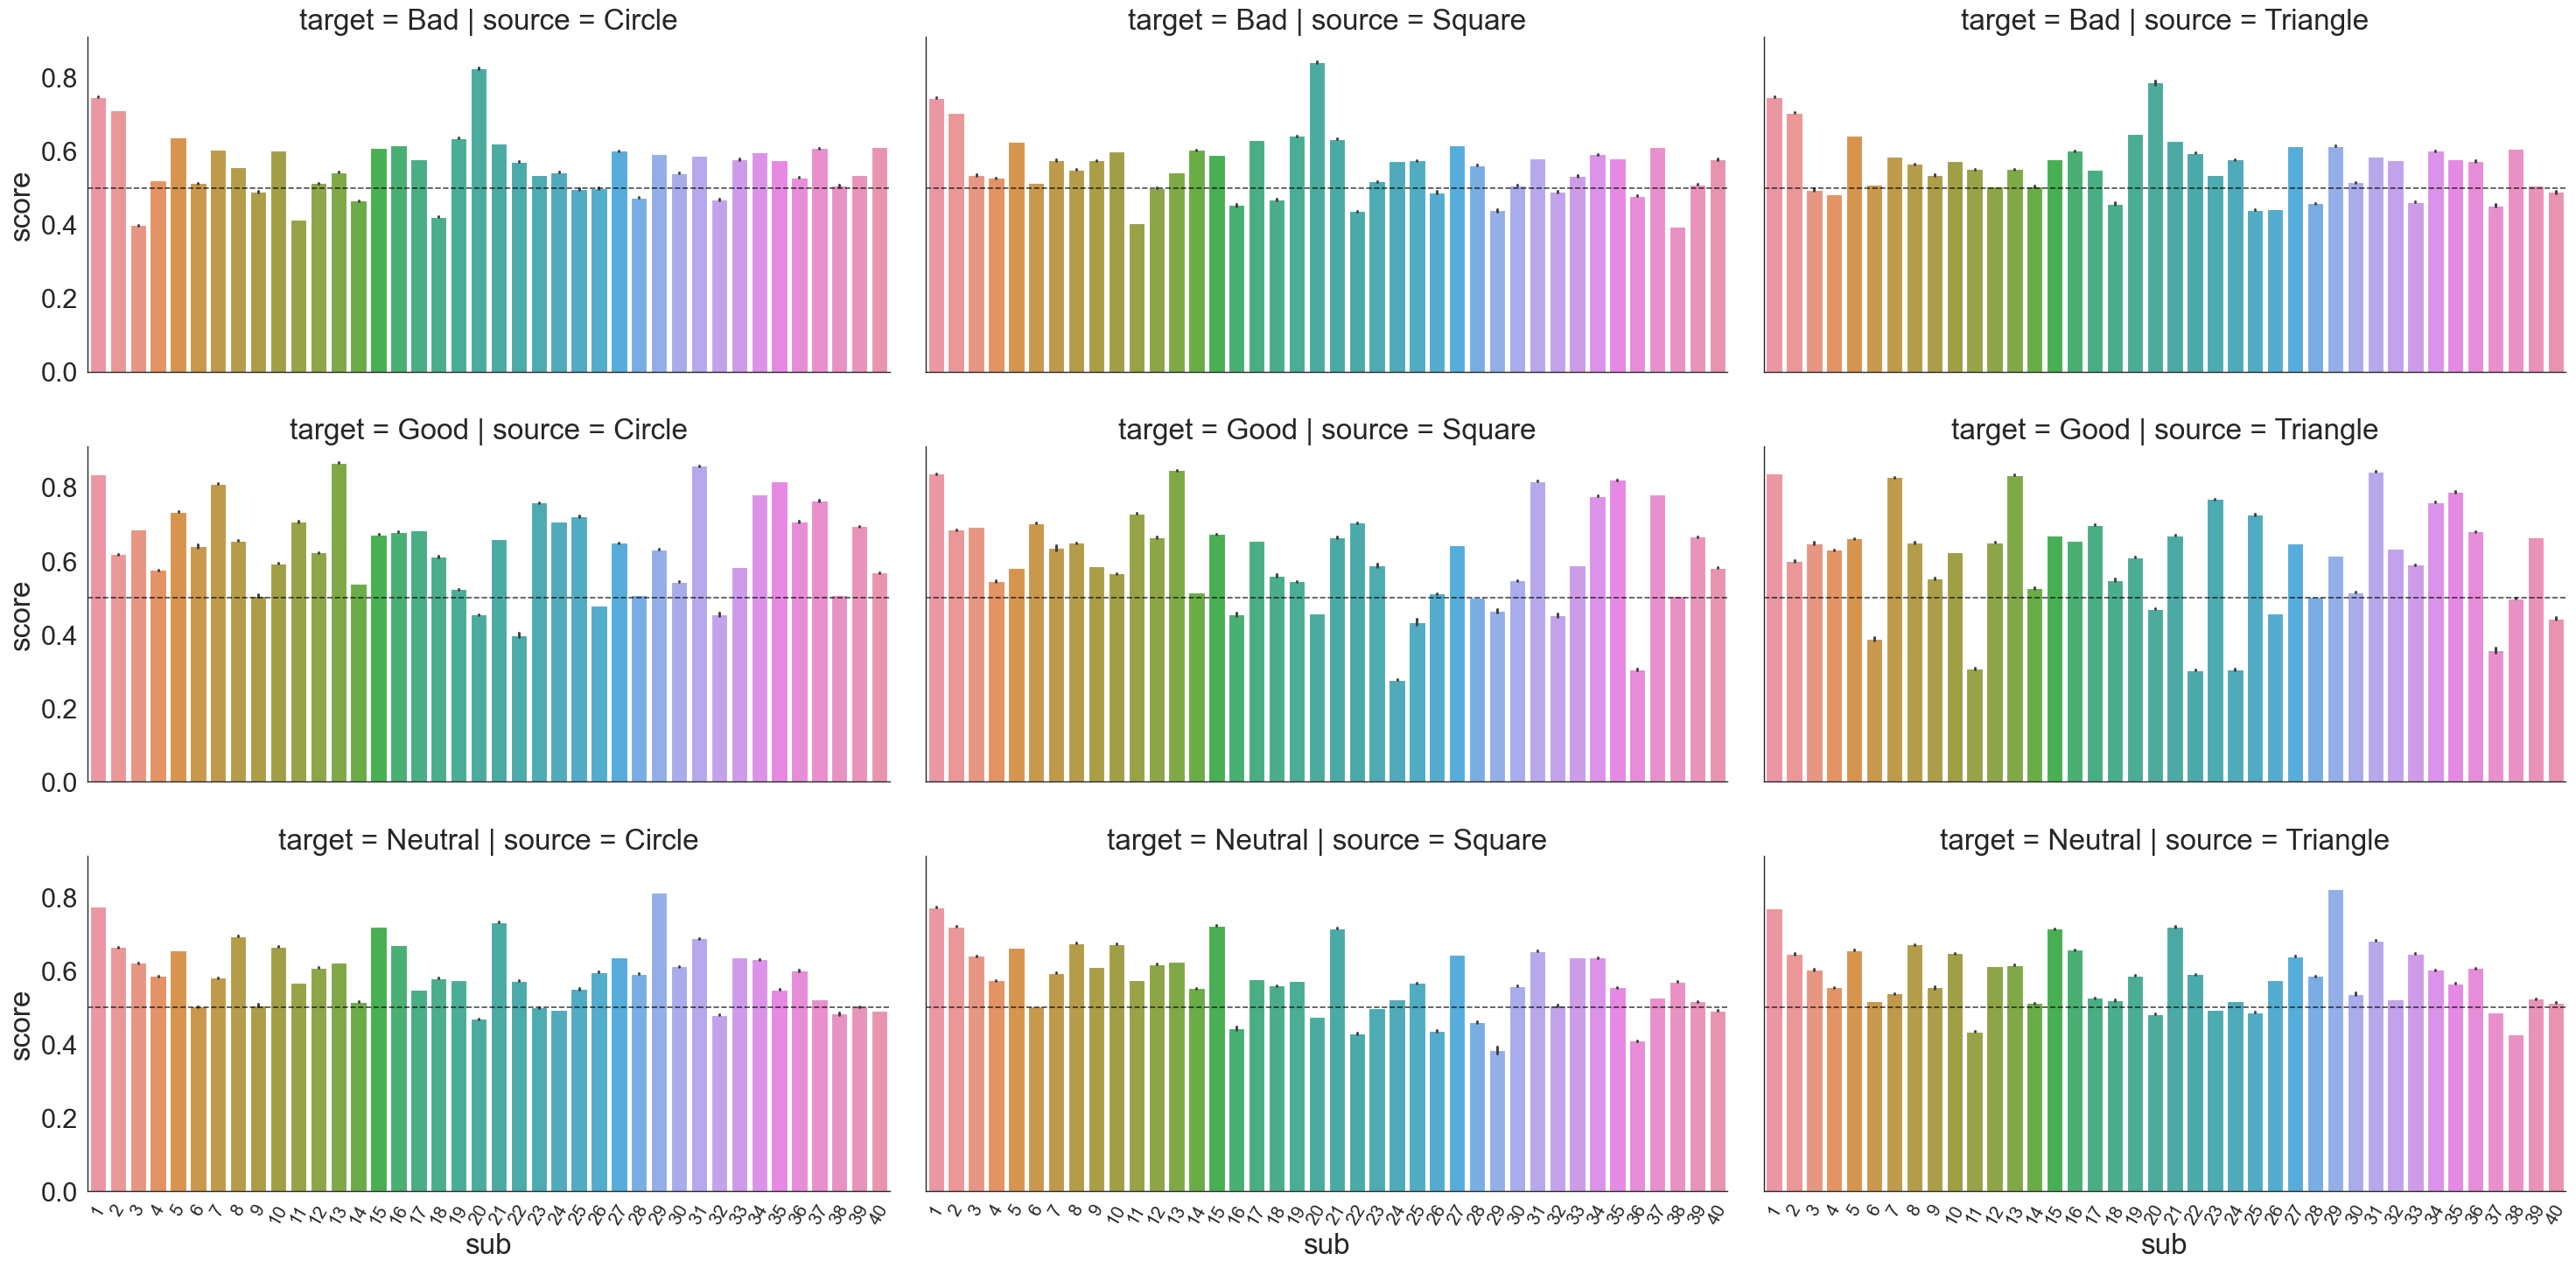

In [108]:
f_cro12 = sns.catplot(x="sub", y="score", data=df_result3[df_result3.experiment == "exp1 → exp2"], col="source", row = "target", aspect=2, kind="bar", errorbar="se")
xtick_order = list(f_cro12.axes[-1][-1].xaxis.get_majorticklabels())
[ax.set_xticklabels(xtick_order, rotation = 60, fontsize=15) for ax in f_cro12.axes[-1]]
[ax.axhline(0.5, linestyle = '--',color = 'black',alpha = 0.7) for ax in f_cro12.axes.flatten()]
plt.savefig("barplot_valence_cro_exp12.png",dpi=300)

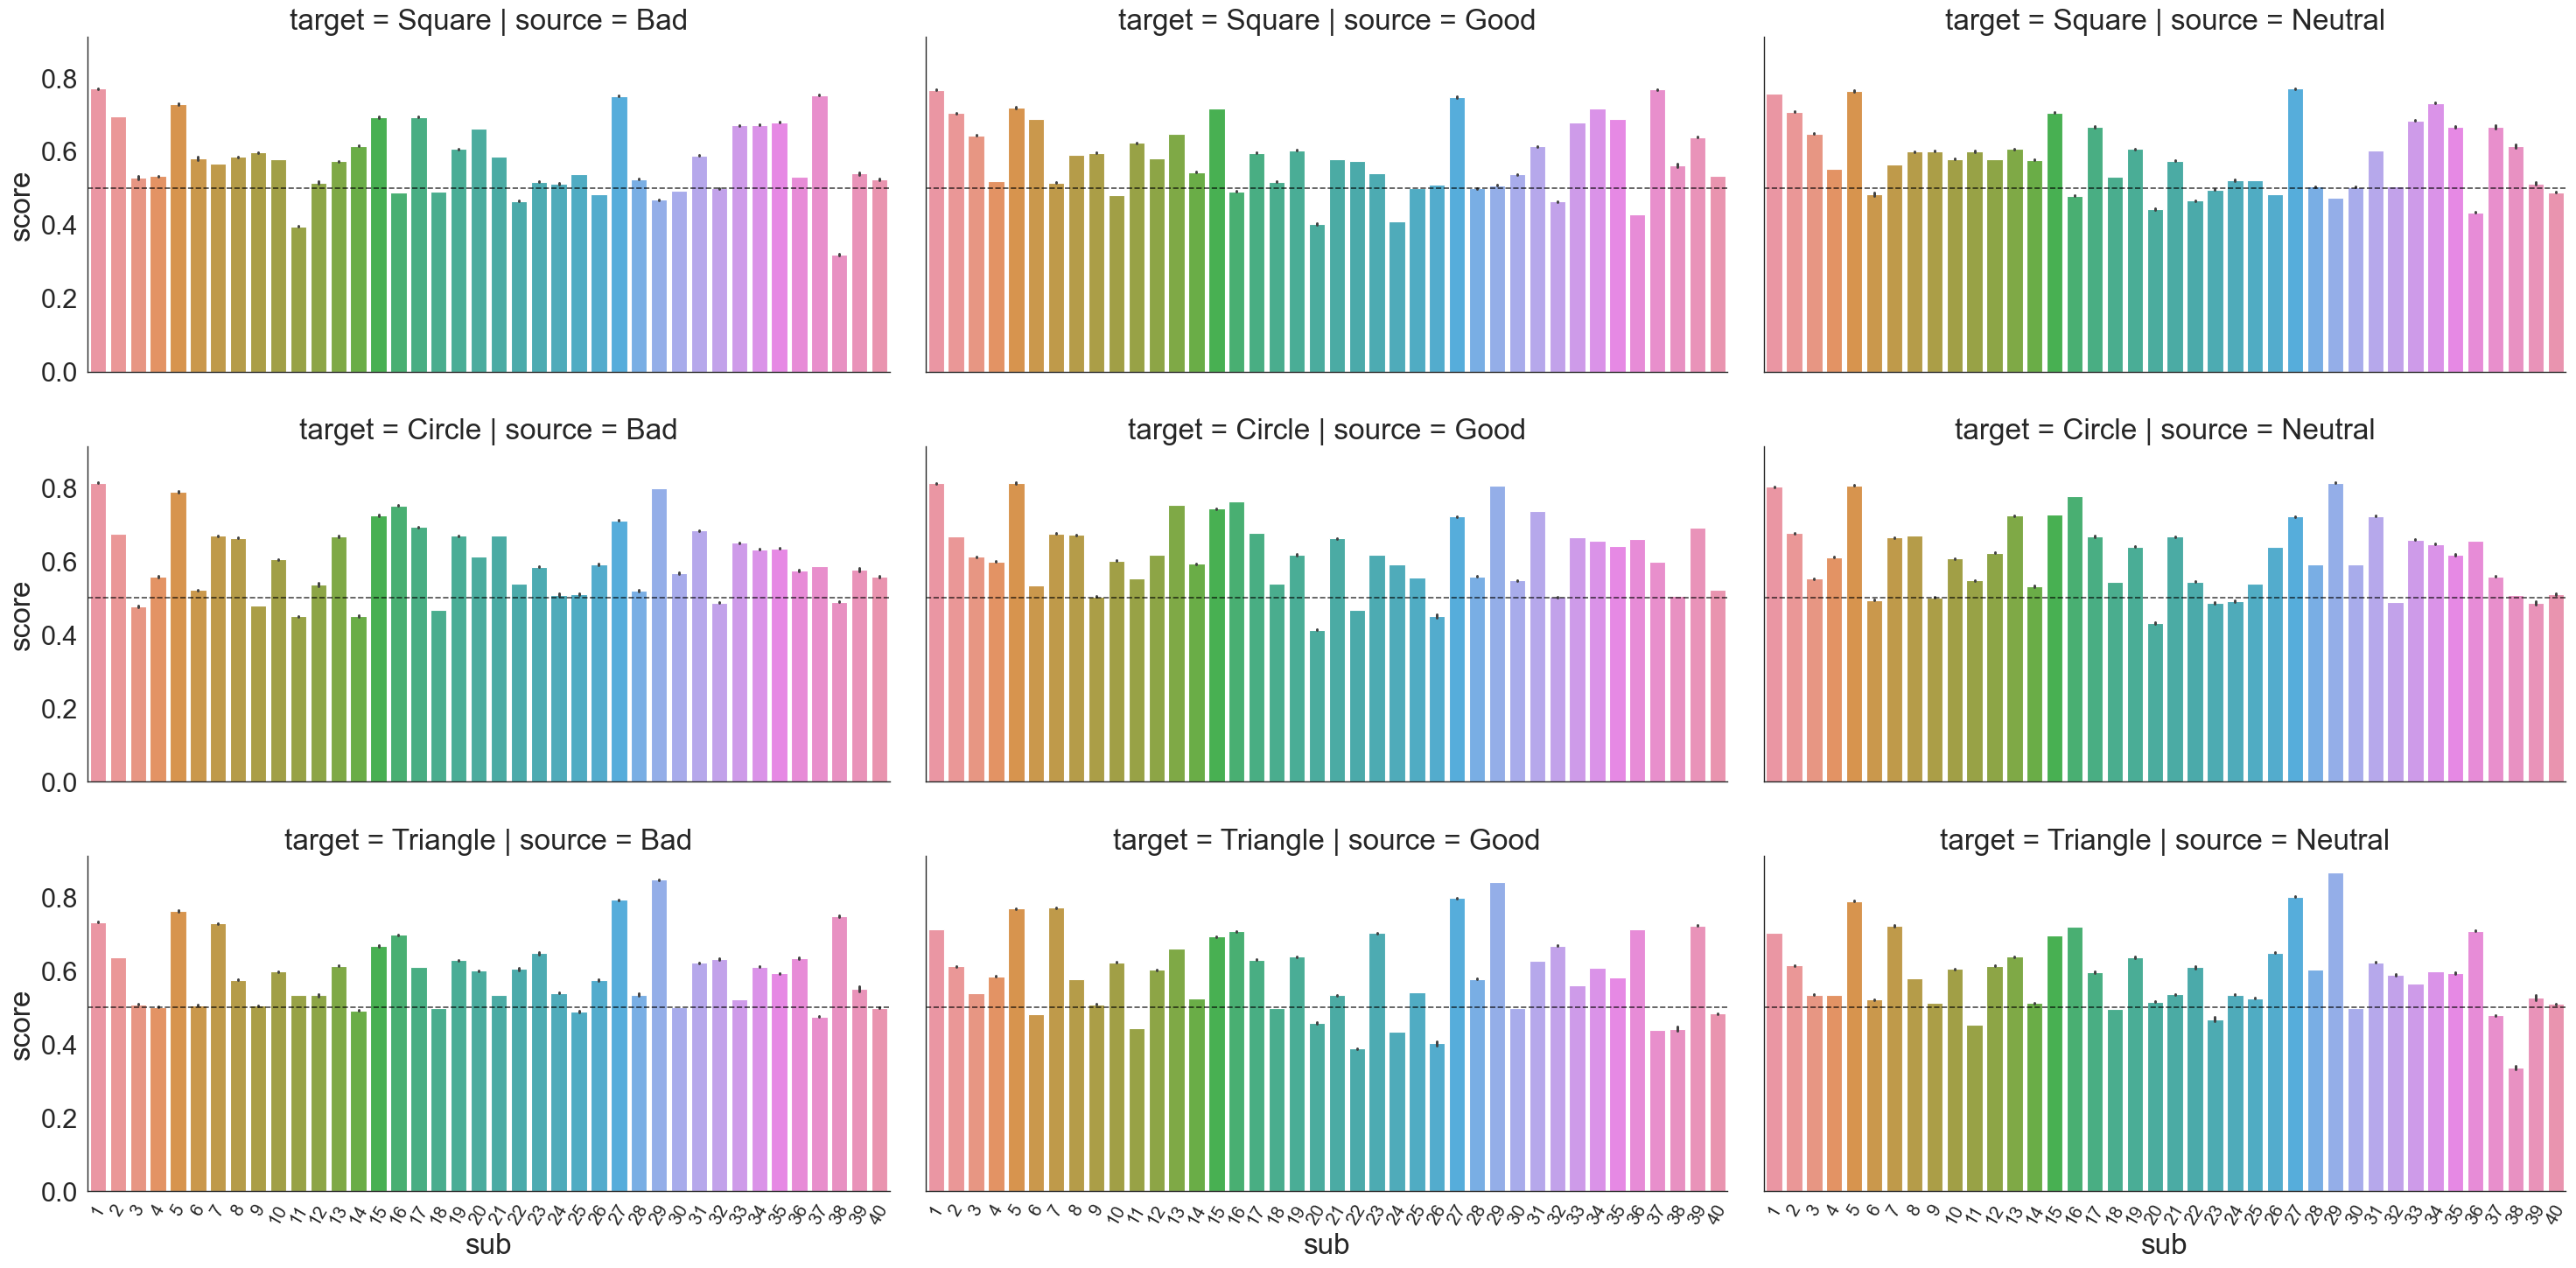

In [109]:
f_cro21 = sns.catplot(x="sub", y="score", data=df_result3[df_result3.experiment == "exp2 → exp1"], col="source", row = "target", aspect=2, kind="bar", errorbar="se")
xtick_order = list(f_cro21.axes[-1][-1].xaxis.get_majorticklabels())
[ax.set_xticklabels(xtick_order, rotation = 60, fontsize=15) for ax in f_cro21.axes[-1]]
[ax.axhline(0.5, linestyle = '--',color = 'black',alpha = 0.7) for ax in f_cro21.axes.flatten()]
plt.savefig("barplot_valence_cro_exp21.png",dpi=300)